Import bibliotek

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from imblearn.over_sampling import SMOTE
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Wczytanie danych

In [ ]:
df = pd.read_csv("spam.csv", encoding="latin-1")

Podgląd pierwszych wierszy

In [ ]:
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


Sprawdzenie dostępnych kolumn

In [ ]:
print(df.columns)

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


Usunięcie zbędnych kolumn

In [ ]:
df = df[["v1", "v2"]]

Zmiana nazw kolumn

In [ ]:
df.columns = ["label", "message"]

Sprawdzenie podstawowych informacji o danych

In [ ]:
print(df.columns)

Index(['label', 'message'], dtype='object')


In [ ]:
print(df.shape)

(5572, 2)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [ ]:
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
print(df.nunique())

label         2
message    5169
dtype: int64


In [ ]:
print(df.isnull().sum())

label      0
message    0
dtype: int64


In [ ]:
print(df.duplicated(subset="message").sum())

403


In [ ]:
print(df[df.duplicated(subset="message")].head(5))

    label                                            message
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


Usuwamy duplikaty

In [ ]:
df = df.drop_duplicates(subset="message").reset_index(drop=True)

Sprawdzamy ilość przykładów w każdej klasie

In [ ]:
print(df['label'].value_counts())

label
ham     4516
spam     653
Name: count, dtype: int64


Wizualizacja

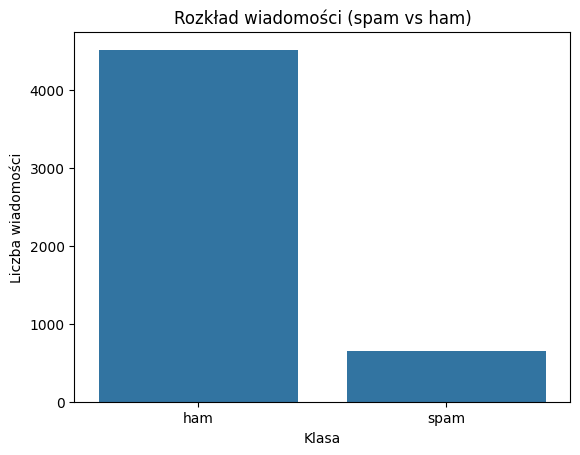

In [ ]:
sns.countplot(data=df, x='label')
plt.title("Rozkład wiadomości (spam vs ham)")
plt.xlabel("Klasa")
plt.ylabel("Liczba wiadomości")
plt.show()

Rozkład procentowy

In [ ]:
print(df['label'].value_counts(normalize=True) * 100)

label
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64


Dodajemy kolumnę z liczbą znaków w wiadomości

In [ ]:
df['length'] = df['message'].apply(len)

Wykres histogramu z podziałem na klasy

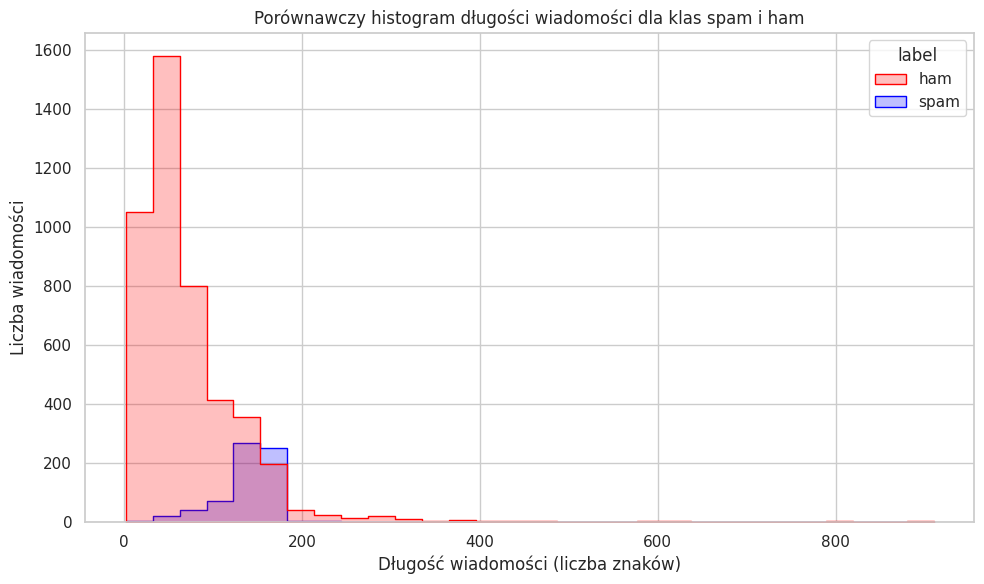

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='length',
    hue='label',
    element='step',
    stat='count',
    common_norm=False,
    bins=30,
    palette=['red', 'blue']
)

plt.title('Porównawczy histogram długości wiadomości dla klas spam i ham')
plt.xlabel('Długość wiadomości (liczba znaków)')
plt.ylabel('Liczba wiadomości')
plt.tight_layout()
plt.show()

Wizualizacja najczęściej wystepujących słów

In [ ]:
spam_words = " ".join(df[df['label'] == 'spam']['message'])
ham_words = " ".join(df[df['label'] == 'ham']['message'])

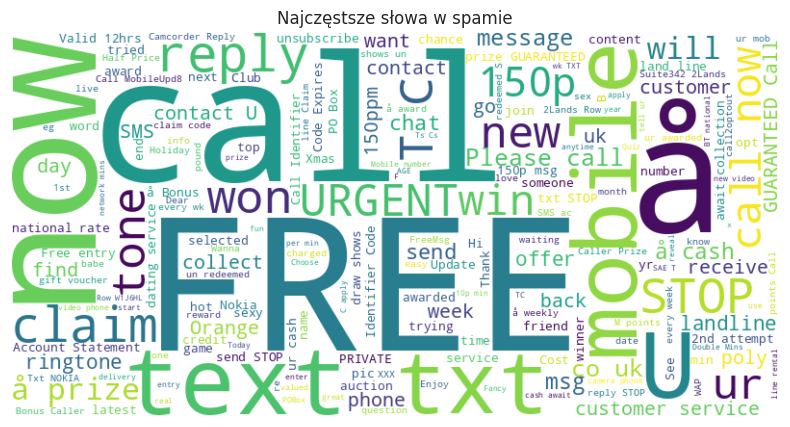

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Najczęstsze słowa w spamie")
plt.axis('off')
plt.show()

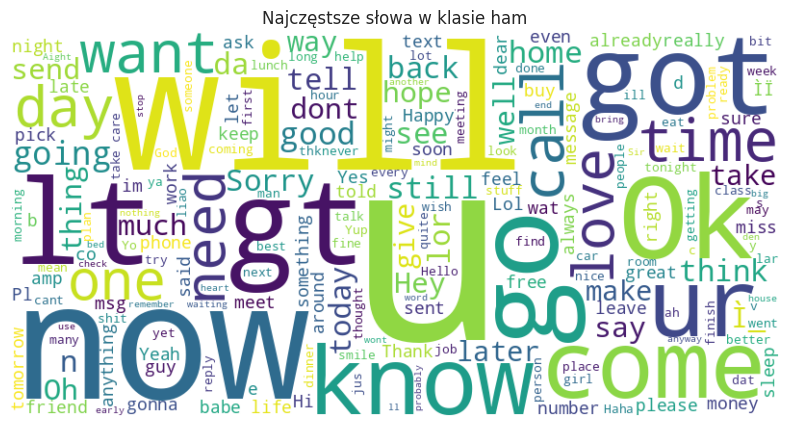

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Najczęstsze słowa w klasie ham")
plt.axis('off')
plt.show()

Oczyszczanie danych

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    alphanumeric_words = [word for word in word_list if word.isalnum()]
    filtered_words = [word for word in alphanumeric_words if word not in stop_words and word not in string.punctuation]
    return " ".join(filtered_words)

Dodanie kolumny z oczyszczonymi danymi tekstowymi

In [ ]:
df['transformed_text'] = df['message'].apply(clean_text)

Wizualizacja top 15 słów w spam i ham, po oczyszczeniu danych

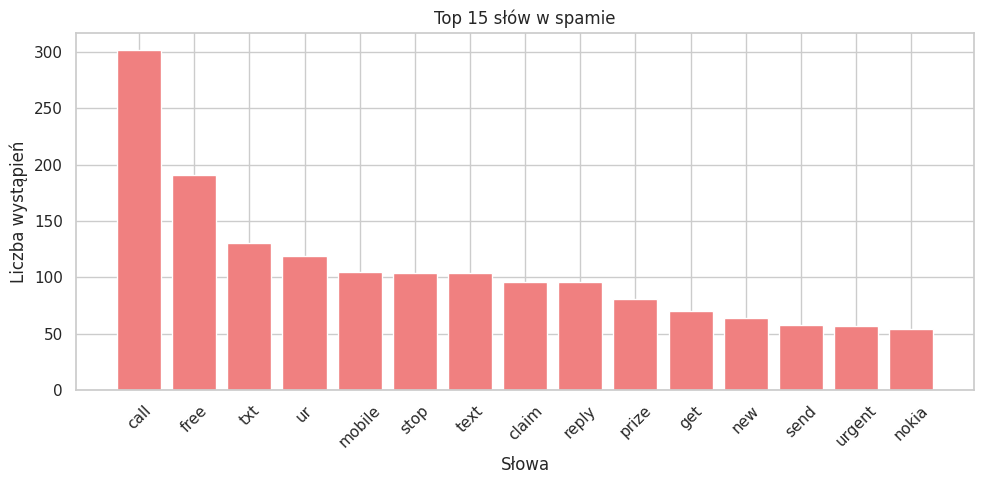

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['label'] == 'spam']['transformed_text'])

word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
top_words = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)[:15]

plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_words), color='lightcoral')
plt.xticks(rotation=45)
plt.title("Top 15 słów w spamie")
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.tight_layout()
plt.show()

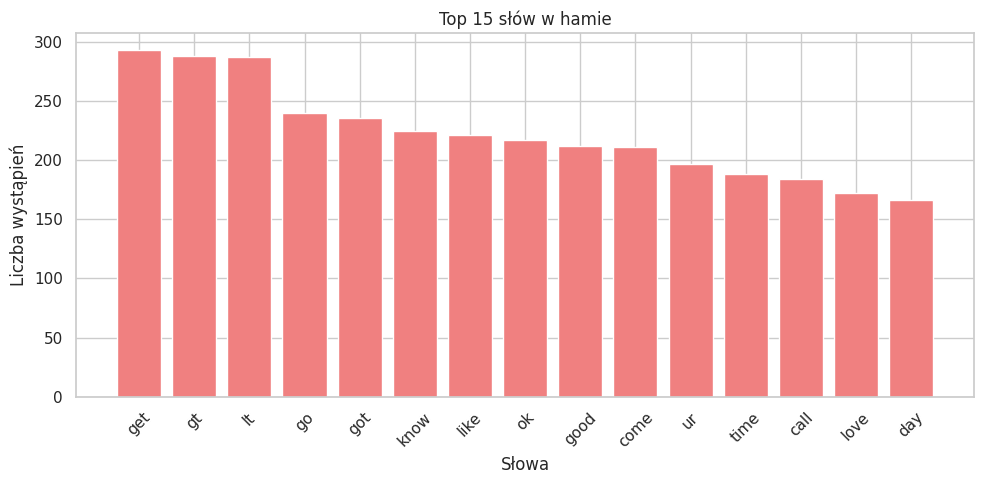

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['label'] == 'ham']['transformed_text'])

word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
top_words = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)[:15]

plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_words), color='lightcoral')
plt.xticks(rotation=45)
plt.title("Top 15 słów w hamie")
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.tight_layout()
plt.show()

Dodanie kolumn z liczbą słów oraz znaków w wiadomości (po oczyszczeniu)

In [ ]:
df['num_characters']=df['transformed_text'].apply(len)
df['num_words']=df['transformed_text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [ ]:
print(df.describe())

            length  num_characters    num_words
count  5169.000000     5169.000000  5169.000000
mean     78.977945       48.693171     8.772103
std      58.236293       37.198773     6.436092
min       2.000000        0.000000     0.000000
25%      36.000000       21.000000     4.000000
50%      60.000000       37.000000     7.000000
75%     117.000000       70.000000    12.000000
max     910.000000      411.000000    74.000000


Dodanie etykiety 0 oraz 1 dla ham i spam

In [ ]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print(df[['label', 'label_num']].head())

  label  label_num
0   ham          0
1   ham          0
2  spam          1
3   ham          0
4   ham          0


Tworzymy macierz cech TF-IDF na podstawie przetworzonego tekstu i konwertujemy ją na gęstą tablicę numpy

In [ ]:
cv=CountVectorizer()
tfidf=TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [ ]:
X.shape

(5169, 8002)

Podział na zbiór testowy oraz treningowy

In [ ]:
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Budowanie modelu - podejście pierwsze

In [ ]:
# Model 1 – Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

# Model 2 – Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Model 3 – Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)

# Model 4 – Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

#Wyniki

print("Multinomial Naive Bayes")
print(classification_report(y_test, y_pred_mnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mnb))

print("\nLogistic Regression")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\nBernoulli Naive Bayes")
print(classification_report(y_test, y_pred_bnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bnb))

print("\nGaussian Naive Bayes")
print(classification_report(y_test, y_pred_gnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gnb))

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       1.00      0.72      0.84       145

    accuracy                           0.96      1034
   macro avg       0.98      0.86      0.91      1034
weighted avg       0.96      0.96      0.96      1034

Confusion Matrix:
 [[889   0]
 [ 41 104]]

Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       889
           1       0.93      0.62      0.74       145

    accuracy                           0.94      1034
   macro avg       0.93      0.81      0.85      1034
weighted avg       0.94      0.94      0.93      1034

Confusion Matrix:
 [[882   7]
 [ 55  90]]

Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.97      0.77      0.86       145

    accuracy                  

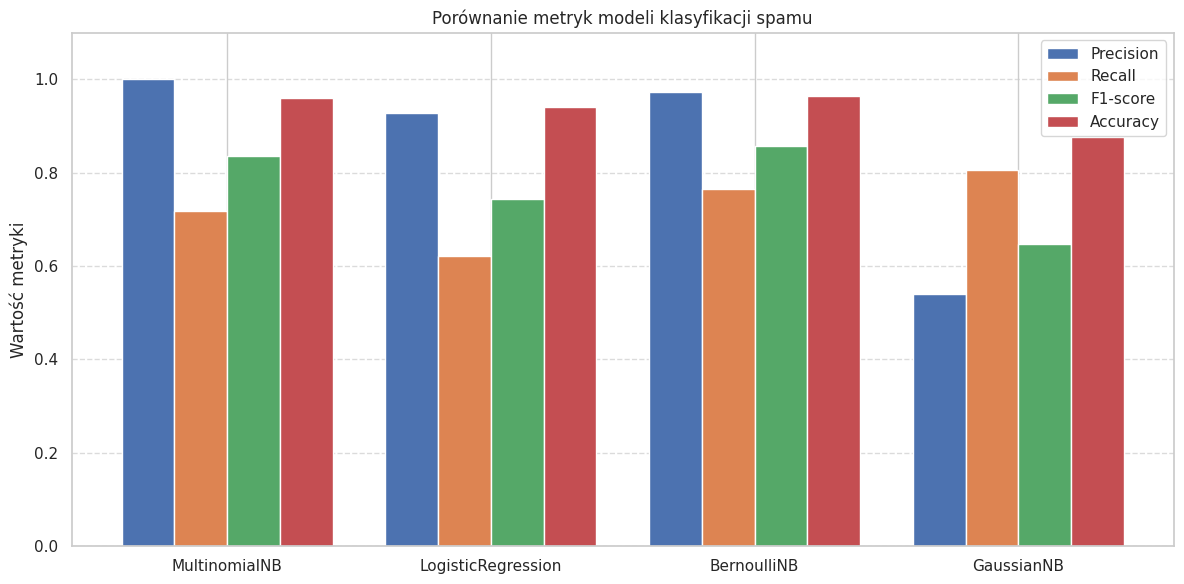

In [ ]:
models = ['MultinomialNB', 'LogisticRegression', 'BernoulliNB', 'GaussianNB']
y_preds = [y_pred_mnb, y_pred_lr, y_pred_bnb, y_pred_gnb]

metrics = {
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Accuracy': []
}

for y_pred in y_preds:
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1-score'].append(f1_score(y_test, y_pred))
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))

# Wykres
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*width, metrics['Precision'], width, label='Precision')
plt.bar(x - 0.5*width, metrics['Recall'], width, label='Recall')
plt.bar(x + 0.5*width, metrics['F1-score'], width, label='F1-score')
plt.bar(x + 1.5*width, metrics['Accuracy'], width, label='Accuracy')

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Wartość metryki")
plt.title("Porównanie metryk modeli klasyfikacji spamu")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

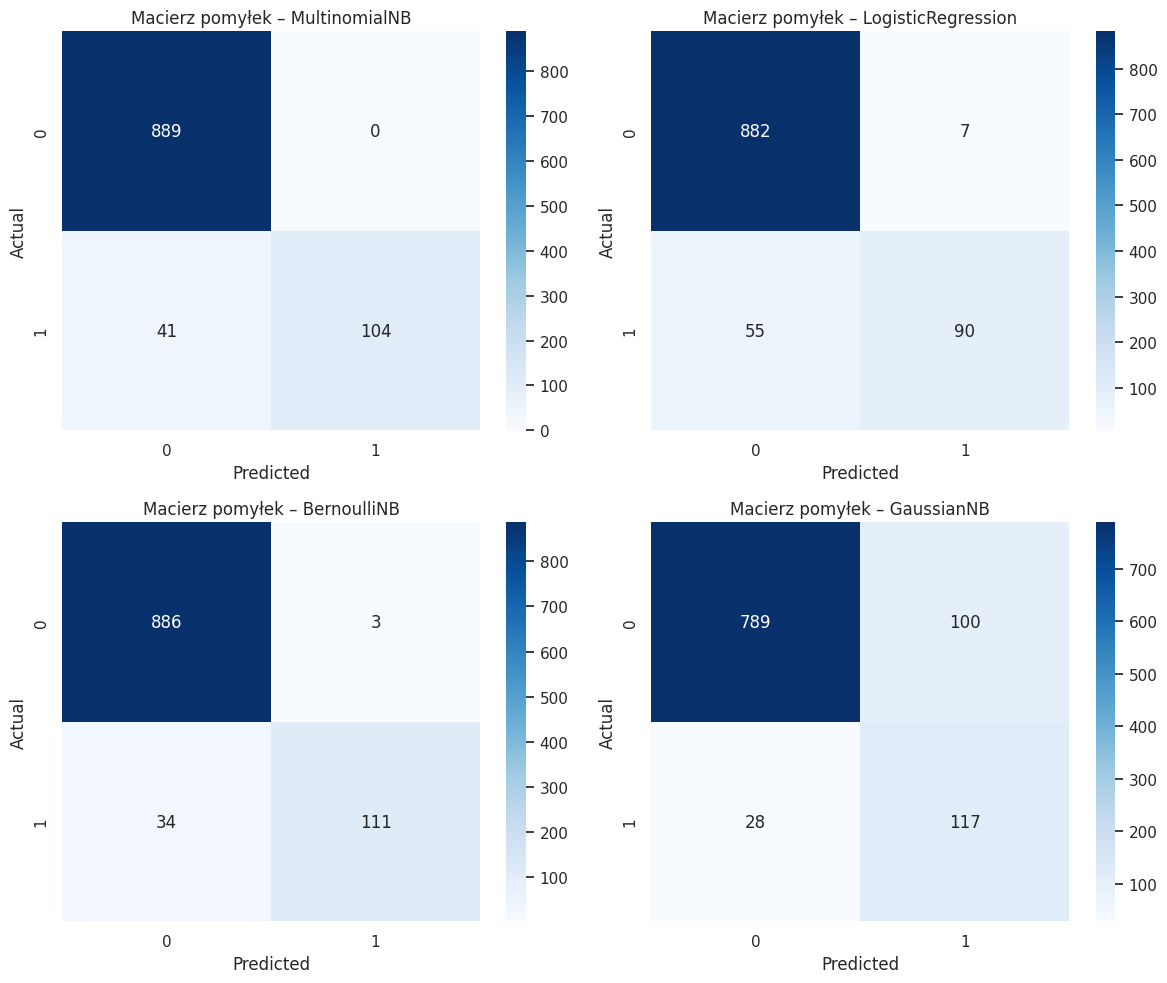

In [ ]:
model_names = ['MultinomialNB', 'LogisticRegression', 'BernoulliNB', 'GaussianNB']
predictions = [y_pred_mnb, y_pred_lr, y_pred_bnb, y_pred_gnb]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, pred, name in zip(axes.ravel(), predictions, model_names):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Macierz pomyłek – {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Ewaluacja modelu - dodanie max_features

In [ ]:
cv=CountVectorizer()
tfidf=TfidfVectorizer(max_features=3500)
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [ ]:
X.shape

(5169, 3500)

In [ ]:
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Budowanie modelu - podejście 2

In [ ]:
# Model 1 – Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

# Model 2 – Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Model 3 – Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)

# Model 4 – Gaussian Naive Bayes (wymaga gęstej macierzy!)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

#Wyniki

print("Multinomial Naive Bayes")
print(classification_report(y_test, y_pred_mnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mnb))

print("\nLogistic Regression")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\nBernoulli Naive Bayes")
print(classification_report(y_test, y_pred_bnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bnb))

print("\nGaussian Naive Bayes")
print(classification_report(y_test, y_pred_gnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gnb))

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       1.00      0.81      0.89       145

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.94      1034
weighted avg       0.97      0.97      0.97      1034

Confusion Matrix:
 [[889   0]
 [ 28 117]]

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       889
           1       0.94      0.70      0.80       145

    accuracy                           0.95      1034
   macro avg       0.94      0.85      0.89      1034
weighted avg       0.95      0.95      0.95      1034

Confusion Matrix:
 [[882   7]
 [ 43 102]]

Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.98      0.83      0.90       145

    accuracy                  

Ulepszanie modelu - oversampling

In [ ]:
# Inicjalizacja SMOTE
smote = SMOTE(sampling_strategy={1: 1000}, random_state=42)

# Oversampling klasy mniejszościowej
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Przed oversamplingiem: {np.bincount(y_train)}")
print(f"Po oversamplingu: {np.bincount(y_train_resampled)}")

# Trenujemy MultinomialNB na danych po oversamplingu
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)

bnb = BernoulliNB()
bnb.fit(X_train_resampled, y_train_resampled)
y_pred_bnb = bnb.predict(X_test)

# Predykcje na zbiorze testowym
y_pred = mnb.predict(X_test)

# Ewaluacja
print("\nMultinomial Naive Bayes")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nBernoulli Naive Bayes")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bnb))


Przed oversamplingiem: [3627  508]
Po oversamplingu: [3627 1000]

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.89      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

Confusion Matrix:
 [[886   3]
 [ 16 129]]

Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.89      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

Confusion Matrix:
 [[886   3]
 [ 17 128]]


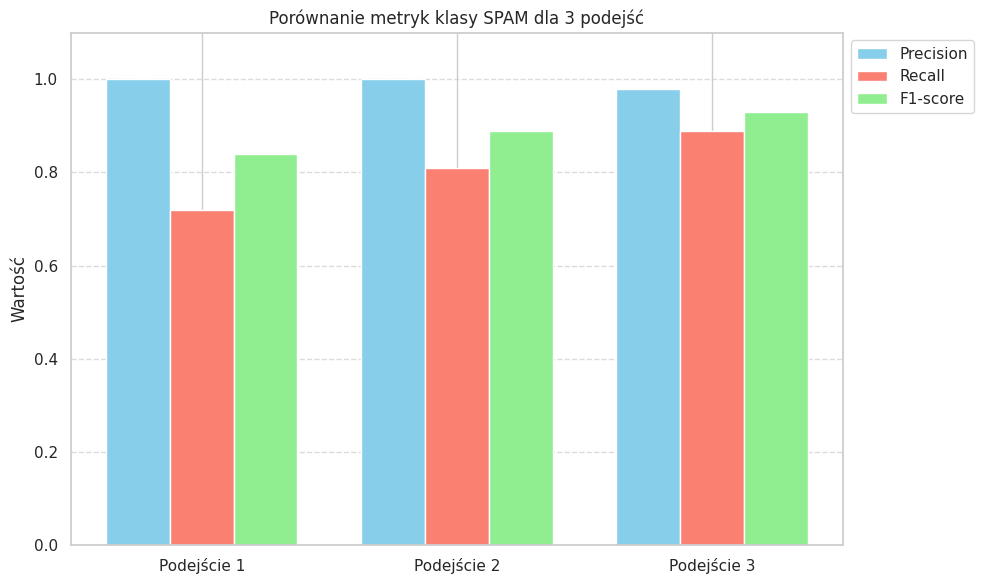

In [ ]:
# Nazwy podejść
models = ['Podejście 1', 'Podejście 2', 'Podejście 3']

# Wartości metryk dla klasy SPAM
precision = [1.00, 1.00, 0.98]
recall =    [0.72, 0.81, 0.89]
f1_score =  [0.84, 0.89, 0.93]

x = np.arange(len(models))  # [0, 1, 2]
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x,         recall,    width, label='Recall', color='salmon')
plt.bar(x + width, f1_score,  width, label='F1-score', color='lightgreen')

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel('Wartość')
plt.title('Porównanie metryk klasy SPAM dla 3 podejść')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()